In [78]:
using OrdinaryDiffEq
using Plots, LaTeXStrings
using CSV
using DataFrames, CategoricalArrays
using Turing
using Dates

In [2]:
figdir = "figures/";

In [3]:
ENV["COLUMNS"]=120
ENV["LINES"]=20;

## Standard virus load function

The standard virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

In [13]:
H(x) = 0.5*(tanh(1e3*x) + 1.)
v₁(t, a₁, a₂, Vmax) = 1. + (Vmax - 1.0)*(tanh(6.0*(t - (a₁ + a₂)/2)/(a₂ - a₁)) - tanh(-3.0*(a₂ + a₁)/(a₂ - a₁)))/2
v₂(t, a₂, α) = 1 - H(t - a₂) + H(t - a₂)*exp(-α*(t - a₂))
v₃(t, b₁, b₂, Vmin) = 1 - (1.0 - Vmin)*(tanh(6.0*(t - (b₁ + b₂)/2)/(b₂ - b₁)) - tanh(-3.0*(b₂ + b₁)/(b₂ - b₁)))/2
function VLF(t, a₁, a₂, b₁, b₂, α, Vmax, Vmin)
    v₁(t, a₁, a₂, Vmax)*v₂(t, a₂, α)*v₃(t, b₁, b₂, Vmin)
end

VLF (generic function with 2 methods)

## Kinetic model

The within-host model for COVID-19 infections dynamics on the lung epithilium, $E$, is given by

$$
\begin{aligned}
    \frac{d E}{dt} & = \mu_E E(1-E) - \delta_E T \frac{V}{V_{max}}.
\end{aligned}
$$ 

In [18]:
function model!(du, u, p, t)
    E, = u
    a₁, a₂, b₁, b₂, α, Vmax, Vmin, μ_E, δ_E = p
    # Lung damage
    du[1] = dE = μ_E*E*(1.0 - E) - δ_E*E*VLF(t, a₁, a₂, b₁, b₂, α, Vmax, Vmin)/Vmax # Healthy lung epithelium
end

model! (generic function with 1 method)

Initial conditions and parameter values

In [80]:
# initial
u0 = [
    1.0   # E: Healthy lung epithilium
]
tspan = (0.0, 40.0)
pars = [
    0.5     # a₁
    4.0     # a₂
    13.0    # b₁
    19.0    # b₂
    0.1     # α
    1e3  # Vmax
    1e-8    # Vmin
    0.01    # μ_E
    0.2     # δ_E
    ]
parnames = [:a₁, :a₂, :b₁, :b₂, :α, :Vmax, :Vmin, :μ_E, :δ_E]
thresholds = (E = 0.3,);
prob = ODEProblem(model!, u0, tspan, pars)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 40.0)
u0: 1-element Vector{Float64}:
 1.0

Solve the ODE problem

## Plotting

Plot the solution in a 3 by 3 grid. 

In [101]:
function plot_sol(sol; kwargs...)
    plot(layout=2, legend=:none, grid=:none, size=(600,300))
    plot_sol!(sol; kwargs...) 
end
function plot_sol!(sol; kwargs...)
    tt = range(0.0, tspan[2], length=100)
    pars = sol.prob.p
    vv = VLF.(sol.t, pars[1], pars[2], pars[3], pars[4], pars[5], pars[6], pars[7])
    plot!(sol.t, vv, lw=3, xaxis=("Time (days)"), yaxis=("Viral load", extrema(vv).*1.05), subplot=1; kwargs...)
    plot!(sol, vars=1, lw=3, xaxis=("Time (days)"), yaxis=("Healthy lung epithelium", (0, 1.1)), subplot=2; kwargs...) 
    plot!(collect(extrema(sol.t)), [thresholds.E, thresholds.E], color=:black, lw=2, subplot=2)
end

plot_sol! (generic function with 1 method)

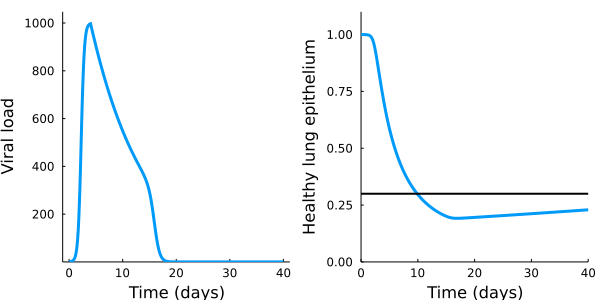

In [102]:
pars = [
    0.5     # a₁
    4.0     # a₂
    13.0    # b₁
    19.0    # b₂
    0.1     # α
    1e3  # Vmax
    1e-8    # Vmin
    0.01    # μ_E
    0.2     # δ_E
    ]
prob = remake(prob, p=pars)
sol = solve(prob, Tsit5(), dtmax=1e-1)
plot_sol(sol)

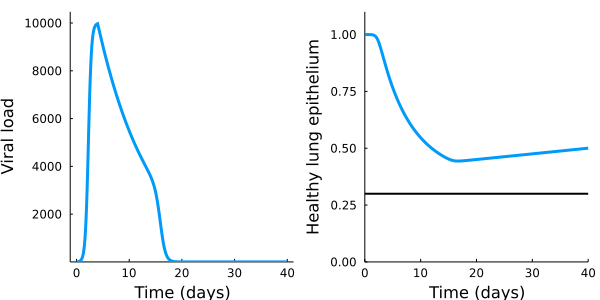

In [104]:
pars = [
    0.5     # a₁
    4.0     # a₂
    13.0    # b₁
    19.0    # b₂
    0.1     # α
    1e4  # Vmax
    1e-8    # Vmin
    0.01    # μ_E
    0.1     # δ_E
    ]
prob = remake(prob, p=pars)
sol = solve(prob, Tsit5(), dtmax=1e-1)
plot_sol(sol)

## Data

In [69]:
df = DataFrame(CSV.File("../../data/AHS/Public/covid19dataexport.csv"))
df = df[df."Case type" .!== "Probable", :]

,Date reported,Alberta Health Services Zone,Gender,Age group,Case status,Case type
,Date,String,String,String,String,String
1,2020-11-13,Calgary Zone,Female,1-4 years,Recovered,Confirmed
2,2021-01-03,Calgary Zone,Female,5-9 years,Recovered,Confirmed
3,2020-12-13,Edmonton Zone,Male,5-9 years,Recovered,Confirmed
4,2021-01-05,Central Zone,Male,50-59 years,Recovered,Confirmed
5,2021-01-30,Calgary Zone,Female,1-4 years,Recovered,Confirmed
6,2021-01-20,Edmonton Zone,Female,Under 1 year,Recovered,Confirmed
7,2020-12-06,Central Zone,Female,10-19 years,Recovered,Confirmed
8,2021-01-14,Calgary Zone,Female,40-49 years,Recovered,Confirmed
9,2020-11-18,Edmonton Zone,Female,10-19 years,Recovered,Confirmed


In [72]:
# unique(df."Case status")
combine(groupby(df, ["Case status"]), nrow => :count)

,Case status,count
,String,Int64
1,Recovered,130969
2,Active,4707
3,Died,1950


## Model
define model


In [107]:
sol.u

401-element Vector{Vector{Float64}}:
 [1.0]
 [0.9999981409708705]
 [0.9999941102014802]
 [0.9999870225837141]
 [0.9999756326613387]
 [0.9999581888654562]
 [0.9999322297098463]
 [0.9998942997409271]
 ⋮
 [0.4987816815288761]
 [0.49903168032688144]
 [0.4992816796090584]
 [0.4995316792504082]
 [0.49978167912593147]
 [0.5000316791106284]
 [0.5002816790794982]

In [73]:
@model probModel(data, prob)
    # priors
    σ ~ InverseGamma(2, 3)
    a₁ ~ Normal(0, 1)
    a₂ ~ Normal(0, 1)
    b₁ ~ Normal(0, 1)
    b₂ ~ Normal(0, 1)
    α ~ Normal(0, 1)
    Vmax ~ Normal(0, 1)
    Vmin ~ Normal(0, 1)
    μ_E ~ Normal(0, 1)
    δ_E ~ Normal(0, 1)

    # model
    prob = remake!(prob, u0 = u0, p = p)

    # solve
    sol = solve(prob, Tsit5(), dtmax=1e-1)

    # predict
    y = ifany(sol.u .< thresholds.E)
    
    # fit
    data ~ Normal(predict, σ)
end

model (generic function with 1 method)